In [1]:
import cv2 as cv
import pickle
import numpy as np
import math
from IPython.core.interactiveshell import InteractiveShell
from matplotlib import pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
d = unpickle('../data/data_batch_1')

In [4]:
s_visited = [0] * 10
pic_array = []
total = 0
for index, labels in enumerate(d[b'labels']):
    if s_visited[labels] == 0:
        pic_array.append(d[b'data'][index].reshape(3, 32, 32))
        total += 1
        s_visited[labels] = 1
        if total >= 10:
            break

In [5]:
len(pic_array)

10

In [6]:
def k_means_img_segmentation(img, k):
    pixel_values = img.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, (centers) = cv.kmeans(pixel_values, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    labels = labels.flatten()
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(img.shape)
    return segmented_image

In [7]:
def mean_shift_img_segmentation(img, quantile):
    pixel_values = img.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    bandwidth = estimate_bandwidth(pixel_values, quantile=quantile, n_samples=None)
    ms = MeanShift(bandwidth=bandwidth, max_iter=500, bin_seeding=False)
    ms.fit(pixel_values)
    labeled = ms.labels_
    segments = np.unique(labeled)
#     print('Number of segments: ', segments.shape[0])
    total = np.zeros((segments.shape[0], 3), dtype=float)
    count = np.zeros(total.shape, dtype=float)
    for i, label in enumerate(labeled):
        total[label] += pixel_values[i]
        count[label] += 1
    avg = total / count
    avg = np.uint8(avg)
    res = avg[labeled]
    result = res.reshape((img.shape))
    return result, segments.shape[0]

In [8]:
def show_all_class(img_list):
    f, axarr = plt.subplots(2, 5, figsize=(20, 8))
    for idx, res in enumerate(img_list):
        row = idx // 5
        col = idx % 5
        axarr[row][col].imshow(res)
    plt.show()

In [9]:
timgs = [img.transpose(1, 2, 0) for img in pic_array]
cv.imwrite('../data/HW4/problem3_results/origin.jpg', cv.cvtColor(timgs[0], cv.COLOR_RGB2BGR))

True

In [10]:
def run_two_cluster(k, q):    
    kimgs = []
    mimgs = []
    mcluster = []
    for img in timgs:
        kimgs.append(k_means_img_segmentation(img, k))
        res, cnum = mean_shift_img_segmentation(img, q)
        mimgs.append(res)
        mcluster.append(cnum)

    print('original picture:')
    show_all_class(timgs)
    print('K-means picture segmentation with {} clusters:'.format(k))
    show_all_class(kimgs)
    print('Mean shift picture segmentation and their cluster numbers', mcluster)
    show_all_class(mimgs)
    
    cv.imwrite('../data/HW4/problem3_results/kmeans_{}.jpg'.format(k), cv.cvtColor(kimgs[0], cv.COLOR_RGB2BGR))
    cv.imwrite('../data/HW4/problem3_results/ms_{}.jpg'.format(q), cv.cvtColor(mimgs[0], cv.COLOR_RGB2BGR))

original picture:


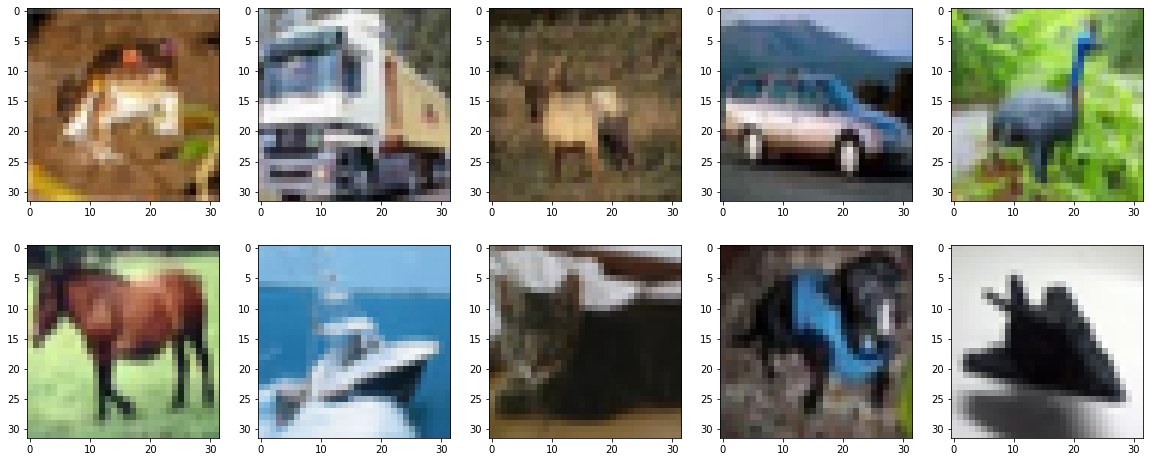

K-means picture segmentation with 14 clusters:


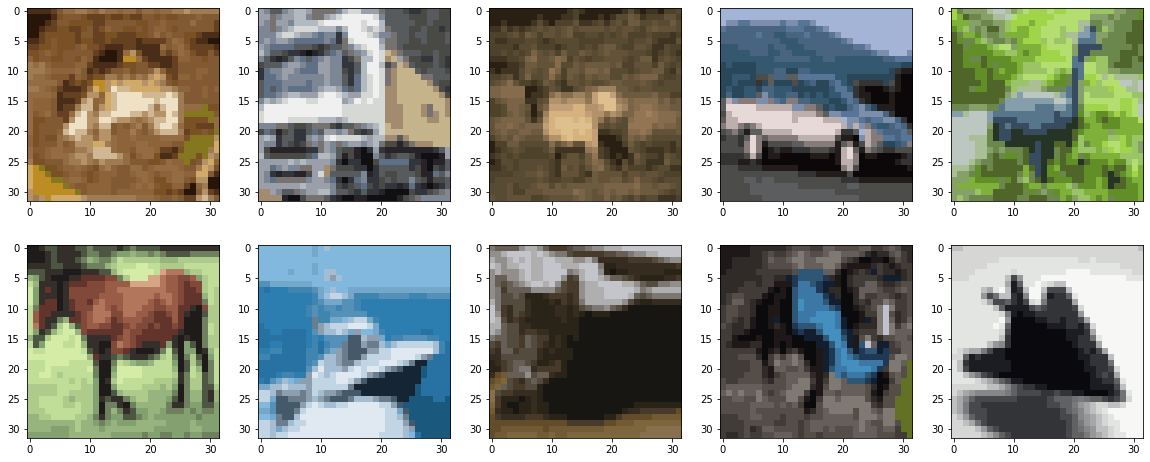

Mean shift picture segmentation and their cluster numbers [18, 13, 11, 18, 14, 12, 17, 15, 18, 17]


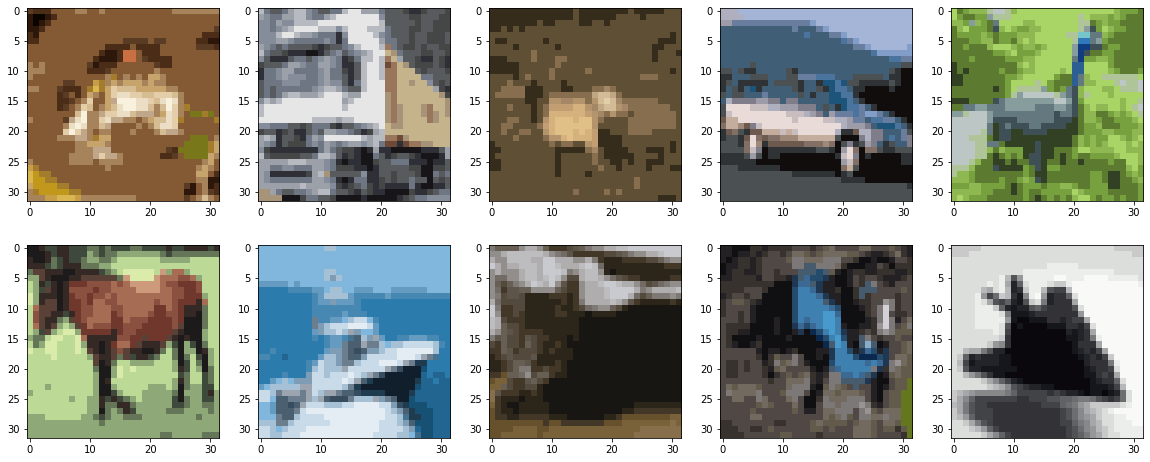

In [11]:
run_two_cluster(14, 0.06)

original picture:


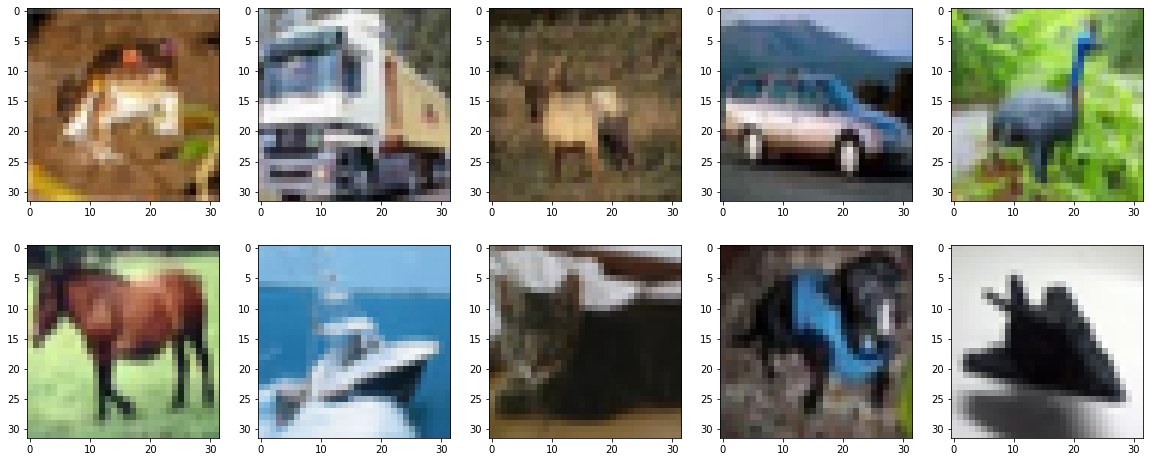

K-means picture segmentation with 5 clusters:


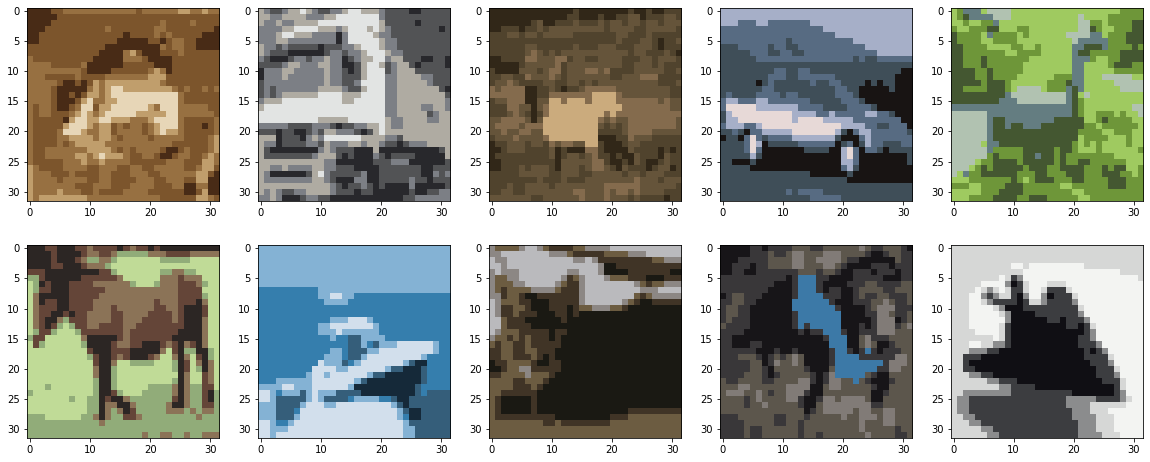

Mean shift picture segmentation and their cluster numbers [6, 6, 7, 7, 9, 9, 9, 7, 9, 12]


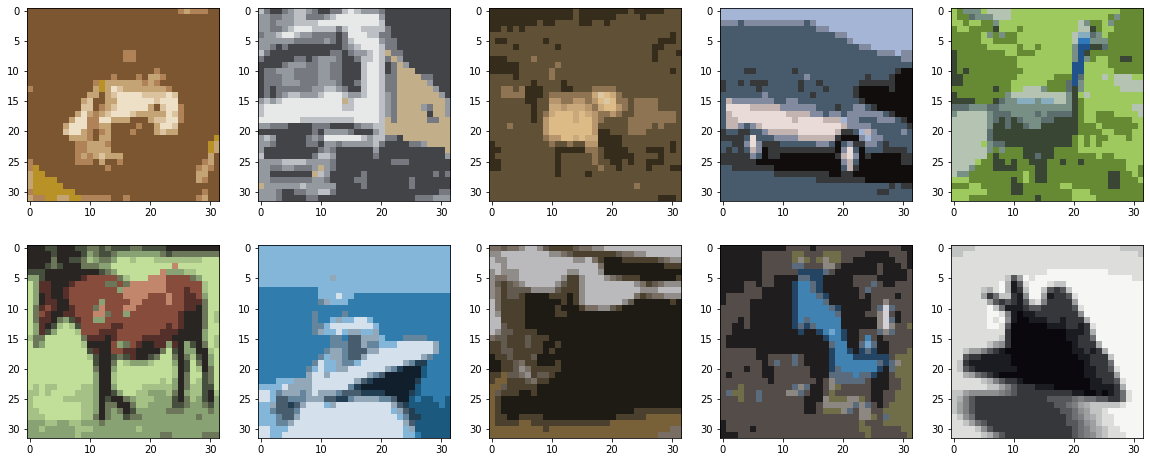

In [12]:
run_two_cluster(5, 0.1)